In [115]:
import sys
import time
import warnings

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedKFold

from studies.utils import *
from pyROMs.pod import POD

warnings.filterwarnings('ignore')

Parse the Data

In [116]:
problem = 'twigl'
case = 1
study = 6

var = None
if problem != 'three_group_sphere':
    var = 'power_density'

print("Loading and formating the data...")
t_start = time.time()
if problem == 'infinite_slab':
    dataset = get_data(problem, case, study)
else:
    dataset = get_data(problem, study)
X = dataset.create_dataset_matrix(var)
Y = dataset.parameters
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")

Loading and formating the data...
Loading the data took 12.430482 s


KFold Cross Validation

In [135]:
n_splits = 10
n_repeats = 500 // n_splits
interior_only = False

tau = 1.0e-8
interp = 'rbf_gaussian'
epsilon = 50.0

cv = {'mean': [], 'max': [], 'min': [],
      'const_time': [], 'query_time': []}

# Define the cross validator and iterator
print(f"Starting Repeated K-Fold cross-validation study...")
cross_validator = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
if interior_only:
    interior = dataset.interior_map
    iterator = cross_validator.split(X[interior], Y[interior])
else:
    iterator = cross_validator.split(X, Y)

# Perform the cross-validations
for train, test in iterator:
    if interior_only:
        boundary = dataset.boundary_map
        X_train, Y_train = X[interior][train], Y[interior][train]
        X_test, Y_test = X[interior][test], Y[interior][test]
        X_train = np.vstack((X_train, X[boundary]))
        Y_train = np.vstack((Y_train, Y[boundary]))
    else:
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]

    # Construct the ROM
    t_start = time.time()
    pod = POD(svd_rank=1.0-tau)
    pod.fit(X_train, Y_train, interp, epsilon=epsilon)
    t_end = time.time()
    cv['const_time'].append(t_end - t_start)

    # Predict the results
    t_start = time.time()
    X_pred = pod.predict(Y_test)
    t_end = time.time()
    cv['query_time'].append((t_end-t_start)/len(test))

    # Format datasets and compute errors
    X_pred = dataset.unstack_simulation_vector(X_pred)
    X_test = dataset.unstack_simulation_vector(X_test)
    errors = np.zeros(len(X_test))
    for i in range(len(X_test)):
        errors[i] = norm(X_test[i]-X_pred[i])/ norm(X_test[i])
    cv['mean'].append(np.mean(errors))
    cv['min'].append(np.min(errors))
    cv['max'].append(np.max(errors))

print()
print(f"Number of POD Modes:\t\t{pod.n_modes}")
print(f"Number of Snapshots:\t\t{pod.n_snapshots}")
print(f"Number of Validations:\t\t{len(X_test)}")
print(f"Average Construction Time:\t{np.mean(cv['const_time']):.3e} s")
print(f"Average Query Time:\t\t{np.mean(cv['query_time']):.3e} s")

Starting Repeated K-Fold cross-validation study...

Number of POD Modes:		16
Number of Snapshots:		58
Number of Validations:		6
Average Construction Time:	4.521e-02 s
Average Query Time:		1.144e-04 s


Plot the Results

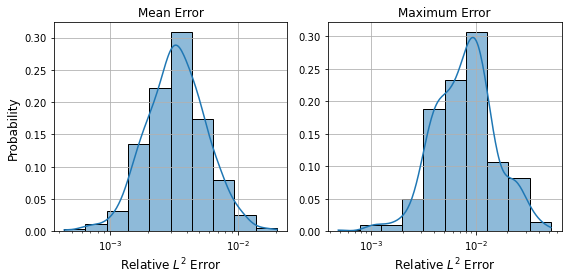

In [136]:
import seaborn as sb
from typing import List
from matplotlib.pyplot import Figure, Axes

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig: Figure = fig
axs: List[Axes] = axs.ravel()

for i, ax in enumerate(axs):
    data = cv['mean'] if i == 0 else cv['max']
    title = "Mean Error" if i == 0 else "Maximum Error"
    ylabel = "Probability" if i == 0 else ""
    sb.histplot(data, bins=10, stat='probability',
                kde=True, log_scale=True, ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Relative $L^2$ Error", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)
plt.tight_layout()

Write LaTeX Table

In [137]:
msg = "\\begin{tabular}{|c|c|c|c|}" \
      "\n\t\hline" \
      "\n\t\\textbf{Quantity} & \\textbf{Value} \\\\ \hline"
msg += f"\n\t \hline Mean of Set Means & {np.mean(cv['mean']):.3e}"
msg += f"\n\t \hline Maximum of Set Means & {np.max(cv['mean']):.3e}"
msg += f"\n\t \hline Minimum of Set Means & {np.min(cv['mean']):.3e}"
msg += f"\n\t \hline Maximum of Set Maximums & {np.max(cv['max']):.3e}"
msg += f"\n\t \hline Minimum of Set Minimums & {np.min(cv['min']):.3e}"
msg += f"\n\t \hline \n \end{{tabular}}"
print(msg)

\begin{tabular}{|c|c|c|c|}
	\hline
	\textbf{Quantity} & \textbf{Value} \\ \hline
	 \hline Mean of Set Means & 3.823e-03
	 \hline Maximum of Set Means & 2.024e-02
	 \hline Minimum of Set Means & 4.378e-04
	 \hline Maximum of Set Maximums & 5.244e-02
	 \hline Minimum of Set Minimums & 1.044e-04
	 \hline 
 \end{tabular}
